# AirBnB : Part 2, Exploratory Data Analysis

In [69]:
%matplotlib inline 

import matplotlib.pyplot as plt

from time import time
import numpy as np
import pandas as pd

import seaborn as sns

import statsmodels.api as sm

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import r2_score, mean_squared_error,confusion_matrix,classification_report
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.grid_search import GridSearchCV

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler,LabelEncoder

from xgboost import XGBClassifier
from utils import rstr,distance

### Add frequency reviews and distance to highlights

In [70]:
df_id = pd.read_csv('../../data/listing_cleansed.csv')
#df_listing = pd.read_csv('../../data/listing_cleansed.csv')

#df_listing = pd.read_csv('../../data/listing_with_reviews_PCA.csv')
df_listing = pd.read_csv('../../data/df_listing_high_renter_with_pic_data.csv')
df_listing= pd.merge(df_listing,df_id[['listing_id','host_id']],on='listing_id')
df_listing.host_id.isnull().sum()

0

In [71]:
df_id.last_review.min()


80.0

In [72]:
df_review_with_lang = pd.read_csv('../../data/reviews_with_lang.csv',index_col=0)

In [73]:
df_review_with_lang.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,language
0,7878281,46630032,2015-09-12,39579628,Roberto,"Host molto gentile e disponibile, l'appartamen...",it
1,7878281,50115386,2015-10-09,45018962,Rotem,"AMAZING hosting, we arrived to Benita's appart...",en
2,7878281,54012898,2015-11-15,47456471,Jochen,"Sehr schöne und ideal gelegene Wohnung, ideal ...",de
3,7878281,58376102,2016-01-02,6789115,Nicola,"This apartment was beautiful, spacious, warm a...",en
4,7878281,71814574,2016-04-28,63494941,Claudio,BENITA AND KLEMENS WERE VERY KIND WITH US. THE...,en


In [74]:
groupy_lang_review = df_review_with_lang.groupby(['listing_id','language'])[['id']].count().unstack().fillna(0)
groupy_lang_review.columns = groupy_lang_review.columns.droplevel()
groupy_lang_review = groupy_lang_review.reset_index()
groupy_lang_review=groupy_lang_review.astype(int)

In [75]:
df_listing = pd.merge(df_listing,groupy_lang_review,on='listing_id')

In [76]:
df_reviews_freq=pd.read_csv('../../data/reviews_frequency.csv')
df = pd.merge(df_listing,df_reviews_freq,on='listing_id')

In [77]:
df_listing.shape

(3196, 642)

In [78]:
coord_brandenburg_tor = (52.516849,13.377661)
def distance_highlight(x):
    return distance(coord_brandenburg_tor,x)
    

In [79]:

df['coordinate']=list(zip(df.latitude, df.longitude))
df['distance_brandenburg_tor'] = df['coordinate'].apply(distance_highlight)

df['listings_per_host']=df.groupby(["host_id"])["listing_id"].transform("count")

df = pd.concat([df,pd.get_dummies(df.text_language,prefix='language_text_')],axis=1)

df['is_multi_host']=( df.listings_per_host>1)*1

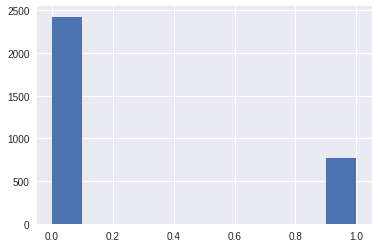

In [80]:
df.is_multi_host.hist()

### Filter on listings with high reviews number

In [81]:
df = df[df.last_review<200]
df = df[df.number_of_reviews>2]
df = df[~df.review_scores_accuracy.isnull()]

### Fill the missing data

In [82]:
columns_fill_na_with_mean = [u'bathrooms', u'bedrooms', u'beds', u'host_since',
       u'host_listings_count','host_response_time','host_response_rate','review_scores_value','review_scores_cleanliness','review_scores_communication','review_scores_location']

df[columns_fill_na_with_mean]= df[columns_fill_na_with_mean].fillna(df[columns_fill_na_with_mean].mean())

In [83]:
df_missing_data = pd.DataFrame(df.isnull().sum()/len(df)*100).sort_values(by=0,ascending=False)
df_missing_data.columns = ['missing_percent']
df_missing_data[df_missing_data.missing_percent>0]

,missing_percent
text_notes,58.421630
text_access,47.679942
text_interaction,45.305079
text_neighborhood_overview,41.834125
text_host_about,39.970771
text_house_rules,33.321155
text_transit,32.078919
text_space,21.556449
text_summary,5.261235
text_name,0.182682


In [84]:
#df.to_csv('../../data/listing_for_EDA.csv',index=None)

## Correlation with target

In [85]:
TARGET = 'host_listings_count'

### Columns to exclude

In [86]:
cols_amenities = [col for col in df.columns if 'amenities' in col]
cols_review_PC = [col for col in df.columns if 'reviews_PC' in col]
cols_picture_PC = [col for col in df.columns if 'pictures_PC' in col]
cols_language_text = [col for col in df.columns if 'language_text' in col]

COLS_EXCLUDE = cols_amenities+cols_review_PC+cols_picture_PC+cols_language_text+['listing_id','host_id','listings_per_host']
COLS_INCLUDE =['reviews_PC_4', 'reviews_PC_3','reviews_PC_8','amenities__Elevatorinbuilding', u'amenities__TV', u'beds',
       u'reviews_PC_13',u'amenities__Shampoo', u'amenities__Laptopfriendlyworkspace','pictures_PC_1']
COLS_EXCLUDE = list(set(COLS_EXCLUDE)-set(COLS_INCLUDE))

In [87]:
df_corr = df.corr()[TARGET]
df_corr = pd.DataFrame(df_corr)
df_corr['corr_abs'] = np.abs(df_corr[TARGET])
df_corr = df_corr.sort_values(by='corr_abs',ascending=False)
df_corr.head(30)

,host_listings_count,corr_abs
host_listings_count,1.000000,1.000000
listings_per_host,0.704505,0.704505
is_multi_host,0.429588,0.429588
instant_bookable,0.234392,0.234392
review_scores_communication,-0.214009,0.214009
reviews_PC_4,0.184697,0.184697
reviews_PC_3,-0.178023,0.178023
review_scores_accuracy,-0.176133,0.176133
review_scores_rating,-0.175830,0.175830
availability_365_previous_month,0.168126,0.168126


## Linear Model and R-squared

In [88]:
TARGET_CLASSIFICATION ='is_multi_host'
y = df[TARGET_CLASSIFICATION]
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
X = df.drop([TARGET_CLASSIFICATION,'host_listings_count']+COLS_EXCLUDE,axis=1).select_dtypes(include=numerics)

### Train test split

In [89]:
def balanced_subsample(y, size=None):

    subsample = []

    if size is None:
        n_smp = y.value_counts().min()
    else:
        n_smp = int(size / len(y.value_counts().index))

    for label in y.value_counts().index:
        samples = y[y == label].index.values
        index_range = range(samples.shape[0])
        indexes = np.random.choice(index_range, size=n_smp, replace=False)
        subsample += samples[indexes].tolist()

    return subsample

In [90]:
rebalanced_index = balanced_subsample(y)

In [91]:
X,y = X.loc[rebalanced_index],y.loc[rebalanced_index]

In [92]:
y.value_counts()

1    697
0    697
Name: is_multi_host, dtype: int64

In [93]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,stratify=y)
features = pd.Series(X.columns)
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [94]:
def cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=5):
    gs = GridSearchCV(clf, param_grid=params, cv=n_folds, n_jobs=-1,scoring="recall")
    gs.fit(Xtrain, ytrain)
    
    return gs.best_estimator_

### Logistic Regression

In [95]:
lm = LogisticRegression(C=1e5)
lm.fit(X_train,y_train)
prediction = lm.predict(X_test)
print confusion_matrix(y_test,prediction)
print classification_report(y_test,prediction)

[[105  34]
 [ 31 109]]
             precision    recall  f1-score   support

          0       0.77      0.76      0.76       139
          1       0.76      0.78      0.77       140

avg / total       0.77      0.77      0.77       279



### Random Forest

In [96]:
clf = RandomForestClassifier()
params={}
best_clf = cv_optimize(clf,params,X_train,y_train)

print(best_clf)

prediction = best_clf.predict(X_test)
print confusion_matrix(y_test,prediction)
print classification_report(y_test,prediction)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
[[113  26]
 [ 47  93]]
             precision    recall  f1-score   support

          0       0.71      0.81      0.76       139
          1       0.78      0.66      0.72       140

avg / total       0.74      0.74      0.74       279



###  SVM

In [97]:
clf = SVC()
params={'C':[0.1],
        'kernel':['rbf'],
       'gamma':[5]}
best_clf = cv_optimize(clf,params,X_train,y_train)

print(best_clf)

prediction = best_clf.predict(X_test)
print confusion_matrix(y_test,prediction)
print classification_report(y_test,prediction)


SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=5, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
[[139   0]
 [140   0]]
             precision    recall  f1-score   support

          0       0.50      1.00      0.67       139
          1       0.00      0.00      0.00       140

avg / total       0.25      0.50      0.33       279



/home/ramon/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### XGB

In [98]:
params = {
    'max_depth':[9],
    'min_child_weight':[2],
    'learning_rate' :[0.1],
    'gamma':[0.0],
    'n_estimators':[100]
}

clf = XGBClassifier()

best_clf = cv_optimize(clf,params,X_train,y_train)

print(best_clf)
prediction = best_clf.predict(X_test)
print confusion_matrix(y_test,prediction)
print classification_report(y_test,prediction)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0.0, learning_rate=0.1, max_delta_step=0, max_depth=9,
       min_child_weight=2, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
[[111  28]
 [ 26 114]]
             precision    recall  f1-score   support

          0       0.81      0.80      0.80       139
          1       0.80      0.81      0.81       140

avg / total       0.81      0.81      0.81       279



In [100]:
features_weights = pd.DataFrame.from_dict(best_clf.booster().get_fscore(),orient="index")

In [104]:
features_weights.sort_values(by=0,ascending=False)

,0
f0,151
f23,96
f104,89
f106,87
f105,85
f6,81
f36,76
f100,75
f187,66
f111,63


In [ ]:
features_weights.columns = ['fscore']
print features_weights.shape
features_weights.set_index(features[:99],inplace=True)

In [ ]:
features_weights.sort_values(by='fscore',ascending=False).head(50).plot(kind='bar',title='XGB regressor - Features Importance')
features_weights.sort_values(by='fscore',ascending=False).head(20)

### Keras

In [ ]:

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier

params = {
    'epochs':[500],
     'batch_size':[512]
}

def create_model():

    model = Sequential()
    model.add(Dense(300, input_dim=X_train.shape[1], activation='relu', init='uniform'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    return model


clf = KerasClassifier(build_fn=create_model, verbose=0)

best_clf = cv_optimize(clf,params,X_train,y_train)

print(best_clf)
prediction = best_clf.predict(X_test)
print confusion_matrix(y_test.values,prediction>.5)
print classification_report(y_test.values,prediction>.5)

## K-Means clustering

In [ ]:
#np.random.seed(42)

data = X

n_samples, n_features = X.shape
n_digits = len(np.unique(y))
labels = y


sample_size = 300

print("n_digits: %d, \t n_samples %d, \t n_features %d"
      % (n_digits, n_samples, n_features))


print(79 * '_')
print('% 9s' % 'init'
      '    time  inertia    homo   compl  v-meas     ARI AMI  silhouette')


def bench_k_means(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    print('% 9s   %.2fs    %i   %.3f   %.3f   %.3f   %.3f   %.3f    %.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)))

bench_k_means(KMeans(init='k-means++', n_clusters=n_digits, n_init=10),
              name="k-means++", data=data)

bench_k_means(KMeans(init='random', n_clusters=n_digits, n_init=10),
              name="random", data=data)

# in this case the seeding of the centers is deterministic, hence we run the
# kmeans algorithm only once with n_init=1
pca = PCA(n_components=n_digits).fit(data)
bench_k_means(KMeans(init=pca.components_, n_clusters=n_digits, n_init=1),
              name="PCA-based",
              data=data)
print(79 * '_')

In [ ]:
reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(reduced_data)



# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()